# <center>Trabajo Práctico Computacional 4:<br>Redes Aleatorias</center>

Grupo 9: Facundo Joaquı́n Garcı́a, Agustı́n Brusco, Eitan Sprejer

# Cloning Repo for Data and Imports

In [3]:
import os
directory_path = os.getcwd()
folder_name = os.path.basename(directory_path)
if folder_name == 'content':  # in default colab folder
    if 'CoNet' not in os.listdir():
        !git clone https://github.com/facundojgarcia02/CoNet.git
    os.chdir(r"/content/CoNet/TP4")


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pickle
import pandas as pd
import json
import re

from tqdm import tqdm
from collections import Counter
from scipy.optimize import curve_fit

from matplotlib import rcParams
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['figure.dpi'] = 100
rcParams['legend.fontsize'] = 10
rcParams['axes.labelsize'] = 'large'

CUSTOM_FORMAT = {"with_labels" : False,
                 "node_size": 10, "node_color": "red", "edgecolors": "black",
                 "linewidths": 0.25, "width": 0.25, "edge_color": "black"}

def custom_draw(graph, ax,
                cmap: str = 'viridis',
                size_degree: bool = False,
                **kwargs):
    k_vals = np.array([k for i, k in graph.degree()])
    norm = plt.Normalize(k_vals.min(), k_vals.max())
    colorscale = plt.cm.ScalarMappable(norm, cmap, )
    if size_degree:
        nx.draw(graph,  with_labels=False,
                node_size=10*np.log(1+k_vals/k_vals.max()) +  4,
                node_color=colorscale.to_rgba(k_vals),
                edgecolors="black", edge_color="black",
                linewidths=0.25, width=0.25,
                ax=ax, **kwargs)
    else:
        nx.draw(graph,  with_labels=False,
                node_size=10,
                node_color=colorscale.to_rgba(k_vals),
                edgecolors="black", edge_color="black",
                linewidths=0.25, width=0.25,
                ax=ax, **kwargs)
    return colorscale
    
    

# I. Análisis de leyes libres de escala en redes aleatorias

## 1) Red Erdos Renyi $G(N, p)$

In [ ]:
def erdos_renyi_graph(N: int, p: float, seed: int = 42) -> nx.Graph:
    """
    Red Erdos Renyi a partir de la cantidad de nodos `N` y la probabilidad de enlazarse `p`.
    """
    rng = np.random.default_rng(seed=seed)
    # Construimos una matriz triangular inferior de NxN de numeros aleatorios del 0 al 1.
    rand_array = [np.concatenate([rng.random(n_i,),
                                  np.zeros(N - n_i)]) for n_i in range(N)]
    rand_array = np.array(rand_array)  # Por compatibilidad con colab, evitamos usar un array esparso.
    # Si el valor obtenido es menor que p, nos quedamos.
    A = (rand_array >= (1-p)).astype(int)

    # Nos quedamos con la parte superior, la transpuesta de la misma,
    # y la diagonal para armar una A simétrica.
    A += A.T
    return nx.from_numpy_array(A)


def erdos_renyi_m(N: int, approx_m: int, seed: int = 42) -> nx.Graph:
    """
    Red Erdos Renyi a partir de la cantidad de nodos N y la cantidad de enlaces.
    """
    p = 2*approx_m/(N*(N-1))
    return erdos_renyi_graph(N, p, seed)


### a) $\langle m \rangle = p \cdot N \cdot (N-1) / 2$

In [ ]:
N = 10_000
m = 50_000
p_estim = 2*m/(N*(N-1))
iters = 200

#Esto puede demorar bastante.
try:
    with open("1a.list", "rb") as f:
        m_vals = pickle.load(f)
except FileNotFoundError:
    m_vals = [len(list(erdos_renyi_m(N, m, seed=i).edges())) for i in tqdm(range(iters))]
    with open("1a.list", "wb") as f:
        pickle.dump(m_vals, f)

/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


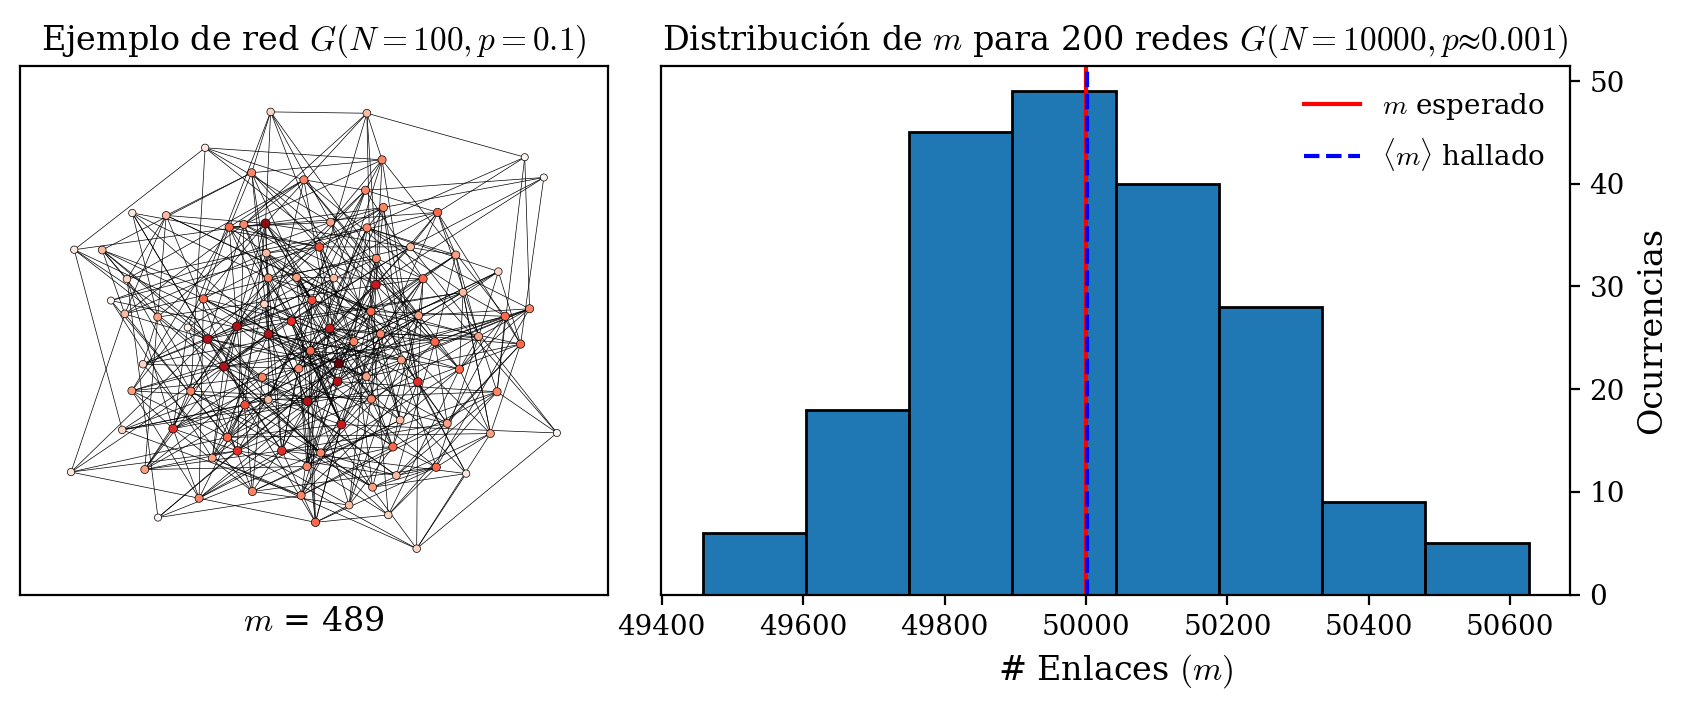

In [ ]:
# subplot_mosaic is not yet allowed in colab
# fig, axs = plt.subplot_mosaic([[0, 1, 1, 1]], figsize=(10, 3.5),
#                               facecolor='w', constrained_layout=True)
fig = plt.figure(figsize=(10, 3.5), facecolor='w', constrained_layout=True)
axs = [plt.subplot2grid((1, 5), (0, 0), 1, 2, fig=fig),
       plt.subplot2grid((1, 5), (0, 2), 1, 3, fig=fig),]

example_net = erdos_renyi_graph(100, 0.1, seed=42)  # Con esta semilla conseguimos una red conectada.
custom_draw(example_net, ax=axs[0], cmap='Reds', size_degree=True)
axs[0].axis(True)
axs[0].set_title(f"Ejemplo de red $G(N={100}, p={0.1})$")
axs[0].set_xlabel(f"$m$ = {len(list(example_net.edges()))}")

axs[1].hist(m_vals, bins=8, ec='k')
axs[1].axvline(m, color = "red", label=r"$m$ esperado")
axs[1].axvline(np.mean(m_vals), ls='--', color="b", label=r"$\langle m\rangle$ hallado")
axs[1].yaxis.tick_right()
axs[1].yaxis.set_label_position("right")
axs[1].legend(frameon=False)
axs[1].set_xlabel("# Enlaces $(m)$")
axs[1].set_ylabel("Ocurrencias")
axs[1].set_title(f"Distribución de $m$ para {iters} redes $G(N={N}, p≈{p_estim:.3g})$")
plt.show()

Al realizar 200 iteraciones de la red aleatoria Erdos renyi con 10000 nodos, 
y guardando la cantidad de enlaces obtenidos por cada realización, observamos que
el $m$ promedio obtenido coincide con el obtenido según la relación 
$m \approx p \frac{N (N-1)}{2}$. Esta relación se puede obtener si se considera
que la probabilidad $p$ es uniforme y la cantidad de enlaces totales posibles
es $\binom{N}{2} = \frac{N (N-1)}{2}$, por ende, la cantidad esperada de enlaces obtenidos
será $\langle m \rangle = p \frac{N (N-1)}{2}$.

### b) $\langle k \rangle = p \cdot (N-1)$

In [ ]:
N_arr = np.arange(100, 10_000, 500)
p = 0.001

try:
    with open("1b.list", "rb") as f:
        k_vals = pickle.load(f)

except FileNotFoundError:
    k_vals = []
    for N in tqdm(N_arr):
        G = erdos_renyi_graph(N, p)
        k_arr = list(dict(G.degree()).values())
        k_mean = np.mean(k_arr)
        k_vals.append(k_mean)

    with open("1b.list", "wb") as f:
        pickle.dump(k_vals, f)

Se tiene el modelo lineal: 〈k〉= p·(n-1) = p·n - p
Pendiente obtenida: 0.001000 ± 0.000004 (Esperado: p = 0.001)
Ordenada al origen obtenida: -0.04 ± 0.02 (Esperado: -p = -0.001)


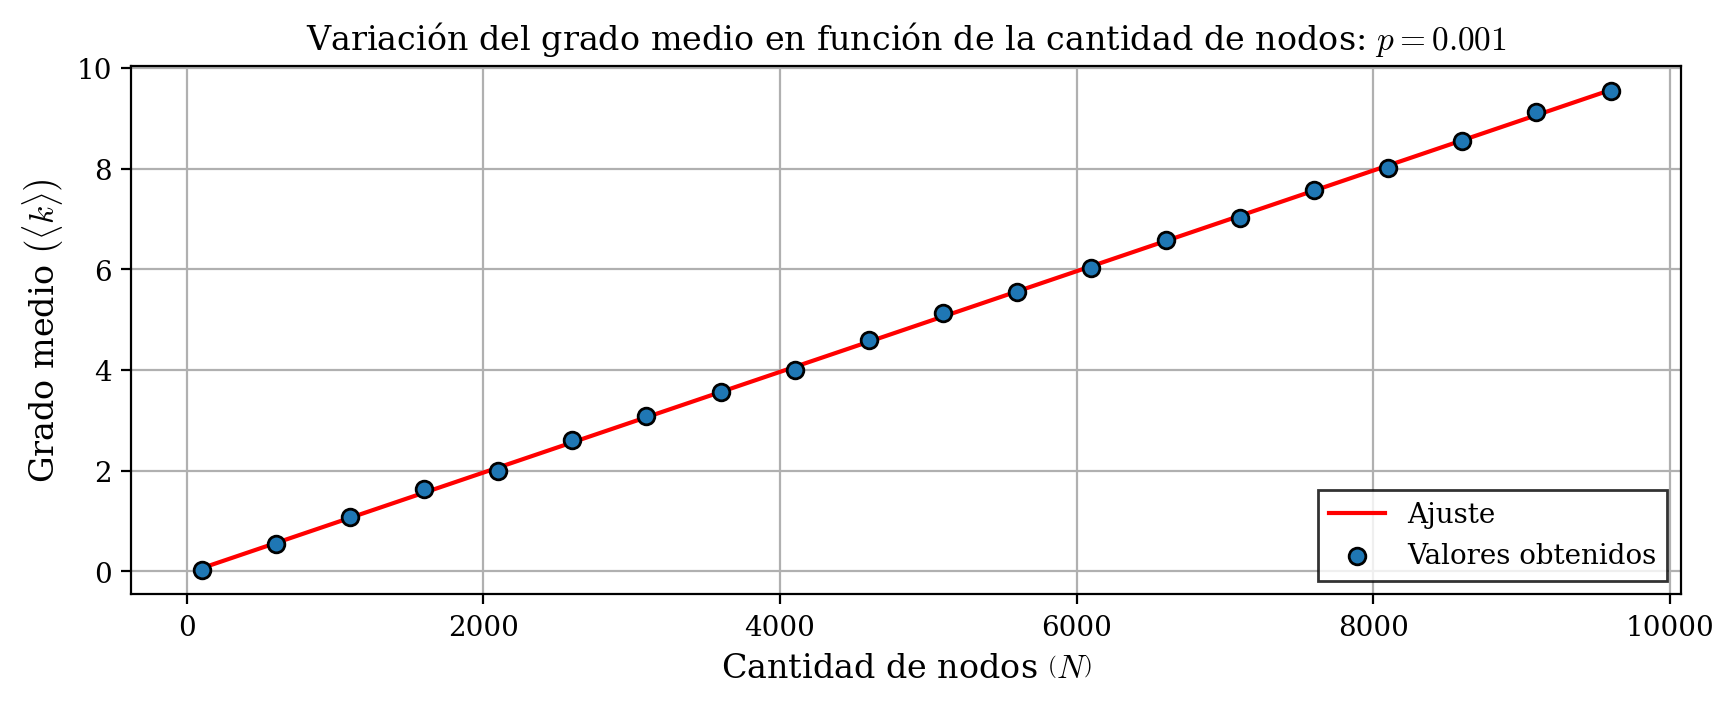

In [ ]:
lineal = lambda x, a, b: a*x+b
popt, pcov = curve_fit(lineal, N_arr, k_vals)
a, b = popt
da, db = np.sqrt(np.diag(pcov))

fig, ax = plt.subplots(1, 1, figsize=(10, 3.5), facecolor='w')

ax.scatter(N_arr, k_vals, ec = "black", label = "Valores obtenidos", zorder=10)
ax.plot(N_arr, lineal(N_arr, *popt), color="red", label="Ajuste", zorder=5)
ax.legend(loc="lower right", fancybox=False, edgecolor="black")
ax.set_xlabel(r"Cantidad de nodos $\left(N\right)$")
ax.set_ylabel(r"Grado medio $\left(\langle k \rangle\right)$")
ax.set_title(f"Variación del grado medio en función de la cantidad de nodos: $p = {p}$")
ax.grid()

print("Se tiene el modelo lineal: 〈k〉= p·(n-1) = p·n - p")
print(f"Pendiente obtenida: {a:.6f} ± {da:.6f} (Esperado: p = {p})")
print(f"Ordenada al origen obtenida: {b:.2f} ± {db:.2f} (Esperado: -p = {-p})")

La suma de los grados equivalente a la cantidad de extremos de cada enlace,
por lo que se tiene:
$$\sum^N k_i = 2 m \approx p N (N-1),$$
Así, el grado medio resulta: $\langle k \rangle = \frac{\sum^N k_i}{N} \approx p (N-1)$.

## 2) Red Aleatoria $G(N, k_0)$

In [ ]:
def random_k0_graph(n: int, k0: int, seed: int = 42) -> nx.Graph:
    """
    Builds a random network with a N nodes and initial k0 degree.
    """
    rng = np.random.default_rng(seed=seed)

    nodes = list(range(k0+1))  # ids
    # Creación incremental de enlaces
    edges = []
    for n1 in nodes:
        # range desde n1+1 porque a medida que n1 aumenta, 
        # nos aseguramos n1 enlaces en los otros ya.
        edges += [(n1, n2) for n2 in range(n1 + 1, max(nodes) + 1)]

    G = nx.Graph(edges)  # Cliqué inicial
    # Agregamos nodos hasta la etiqueta n-1.
    for node in range(k0 + 1, n):
        # Elegimos aleatoriamente k0 nodos a los que nos vamos a enlazar.
        targets = rng.choice(a=nodes, size=k0, replace=False)
        # Agregamos a la lista de nodos el nuevo.
        nodes.append(node)
        # Y a la red el nodo y los k0 enlaces.
        G.add_node(node)
        G.add_edges_from([(node, t) for t in targets])

    return G

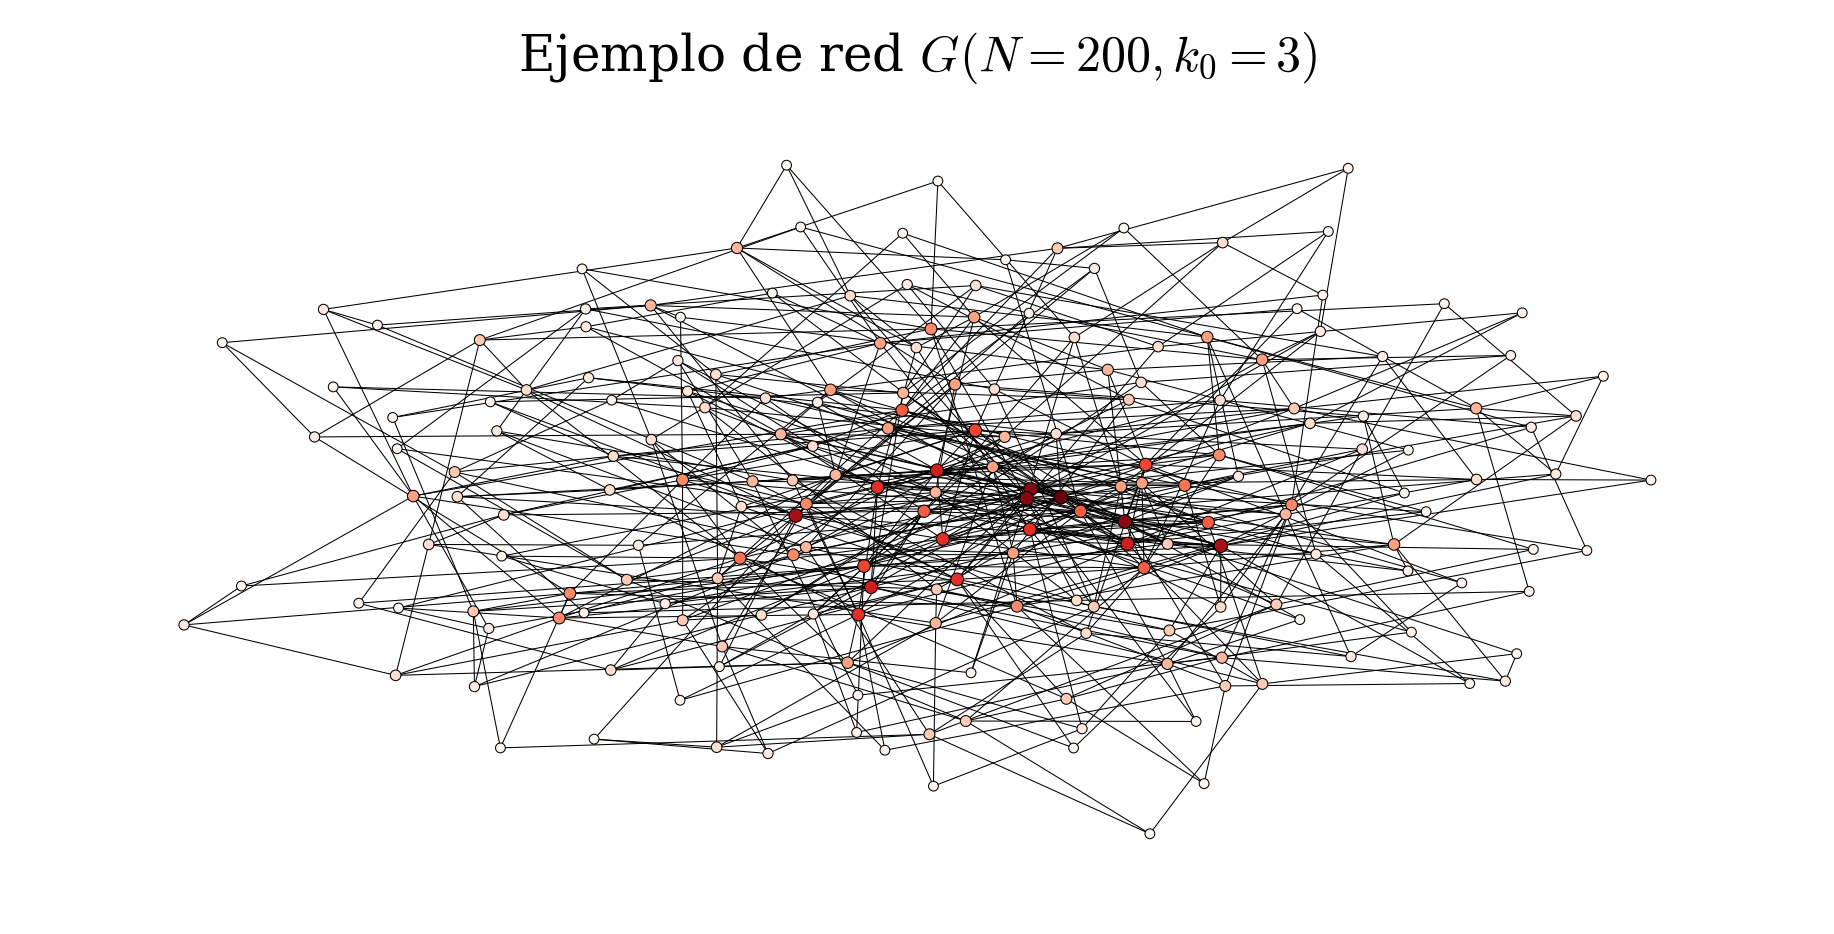

In [ ]:
# Ejemplo:
fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=150,
                       facecolor='w', constrained_layout=True)
example_net = random_k0_graph(200, 3)  # Con esta semilla conseguimos una red conectada.
custom_draw(example_net, ax=ax, cmap='Reds', size_degree=True)
ax.set_title("Ejemplo de red $G(N=200, k_0=3)$")
plt.show()

## 3) Red Barabasi $B(N, k_0)$

In [ ]:
def barabasi_graph(n: int, k0: int, seed: int = 42) -> nx.Graph:
    """
    Builds a random network with a N nodes and initial k0 degree.
    """
    rng = np.random.default_rng(seed=seed)
    nodes = list(range(k0+1))  # ids

    # Creación incremental de enlaces
    edges = []
    for n1 in nodes:
        # range desde n1+1 porque a medida que n1 aumenta, 
        # nos aseguramos n1 enlaces en los otros ya.
        edges += [(n1, n2) for n2 in range(n1 + 1, max(nodes) + 1)]

    G = nx.Graph(edges)

    # Agregamos nodos hasta la etiqueta n-1.
    for node in range(k0 + 1, n):
        degrees = dict(G.degree())
        sorted_degrees = dict(sorted(degrees.items())) # Grados (ordenados).
        k_vec = np.array(list(sorted_degrees.values()))
        p_vec = k_vec/np.sum(k_vec)
        # Elegimos aleatoriamente k0 nodos a los que nos vamos a enlazar.
        targets = rng.choice(a=nodes, size=k0, replace=False,
                             p=p_vec)
        # Agregamos a la lista de nodos el nuevo.
        nodes.append(node)
        # Y a la red el nodo y los k0 enlaces.
        G.add_node(node)
        G.add_edges_from([(node, t) for t in targets])

    return G

### a) $\langle m \rangle = k_0 \cdot N$

In [ ]:
N = 10_000
k0_arr = range(3, 33, 3)
k0_arr = np.array(k0_arr)
#Esto puede demorar bastante.
try:
    with open("3a.list", "rb") as f:
        m_vals = pickle.load(f)

except FileNotFoundError:
    m_vals = []
    for k0 in tqdm(k0_arr):
        G = barabasi_graph(N, k0, seed=k0)
        m = len(list(G.edges()))
        m_vals.append(m)

    with open("3a.list", "wb") as f:
        pickle.dump(m_vals, f)

Se tiene el modelo lineal: 〈m〉= N·k₀
Pendiente obtenida: 9983 ± 1 (Esperado: N = 10000)
Ordenada al origen obtenida: 99 ± 25 (Esperado: 0)


/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


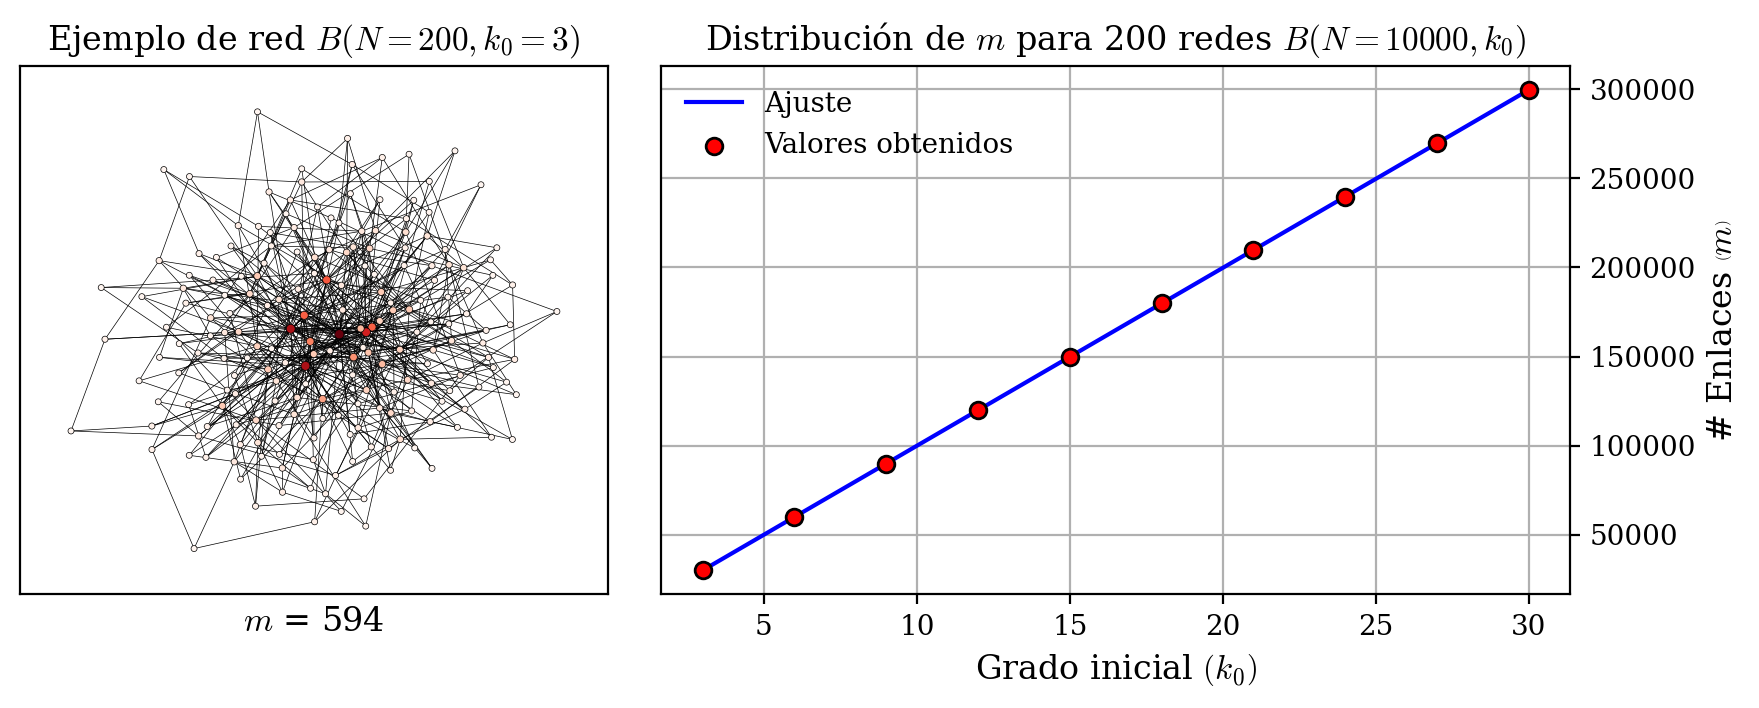

In [ ]:
lineal = lambda x, a, b: a*x+b
popt, pcov = curve_fit(lineal, k0_arr, m_vals)
a, b = popt
da, db = np.sqrt(np.diag(pcov))
print("Se tiene el modelo lineal: 〈m〉= N·k₀")
print(f"Pendiente obtenida: {a:.0f} ± {da:.0f} (Esperado: N = {N})")
print(f"Ordenada al origen obtenida: {b:.0f} ± {db:.0f} (Esperado: 0)")


# fig, axs = plt.subplot_mosaic([[0, 0, 1, 1, 1]], figsize=(10, 3.5),
#                               facecolor='w', constrained_layout=True)
fig = plt.figure(figsize=(10, 3.5), facecolor='w', constrained_layout=True)
axs = [plt.subplot2grid((1, 5), (0, 0), 1, 2, fig=fig),
       plt.subplot2grid((1, 5), (0, 2), 1, 3, fig=fig),]

example_net = barabasi_graph(200, 3, seed=42)
custom_draw(example_net, ax=axs[0], cmap='Reds', size_degree=True)
axs[0].axis(True)
axs[0].set_title("Ejemplo de red $B(N=200, k_0=3)$")
axs[0].set_xlabel(f"$m$ = {len(list(example_net.edges()))}")

axs[1].scatter(k0_arr, m_vals, color="red", ec="black",
               label="Valores obtenidos", zorder=10)
axs[1].plot(k0_arr, lineal(k0_arr, *popt), color="blue",
            label="Ajuste", zorder=5)
axs[1].yaxis.tick_right()
axs[1].grid(True)
axs[1].yaxis.set_label_position("right")
axs[1].legend(frameon=False)
axs[1].set_ylabel(r"# Enlaces $\left(m\right)$")
axs[1].set_xlabel(r"Grado inicial $\left(k_0\right)$")
axs[1].set_title(f"Distribución de $m$ para {iters} redes $B(N={N}, k_0)$")
plt.show()

Los resultados del ajuste lineal al gráfico anterior corroboran la relación $m \approx k_0 N$.
La expresión anterior para la cantidad de enlaces en función de $N$ y $k_0$ se
puede obtener de la siguiente manera:

Dada la construcción de la red, se puede ver que para los $k_0+1$ nodos iniciales, la cantidad de enlaces iniciales será:
$$m_0 = \frac{k_0 (k_0 + 1)}{2},$$
luego se agregan $k_0$ enlaces a cada paso.

Como quedan $N - (k_0+1)$ nodos de grado $k_0$ por añadir, se tiene que
$$\Rightarrow m = m_0 + (N - (k_0+1)) k_0$$
$$\iff m = (N-\frac{k_0+1}{2})k_0.$$
Luego, si $N >> \frac{k_0 + 1}{2}$ se tiene que $m \approx N k_0$

## 4) Comparación con Redes Reales

In [ ]:
def plot_degree_dist(G, ax=None):
    """
    Plot de la distribución de grados de este tipo de red.
    """
    degrees = dict(G.degree())
    degrees_dist = Counter(degrees.values())
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.scatter(degrees_dist.keys(), degrees_dist.values(), ec="black")
    ax.set_xlim(0.8, max(degrees_dist.keys())*1.5)
    return ax.figure, ax


def plot_random_distributions(G: nx.Graph,
                            #   k02: int = 5,
                            #   k03: int = 5,
                              suptitle: str = None):

    N = len(list(G.nodes()))
    m = len(list(G.edges()))
    networks = [G,
                erdos_renyi_m(N, m),
                random_k0_graph(N, int(m/N)),
                barabasi_graph(N , int(m/N)),
                ]

    fig = plt.figure(figsize=(12, 4), constrained_layout=True, facecolor='w')
    axs = fig.subplots(1, 4)
    #Distribución real
    for graph, tag, ax in zip(networks,
                              ["Distribución real", "Erdos Renyi $G(N, p)$",
                               "Random $G(N, k_0)$", "Barabasi $B(N, k_0)$"],
                              axs):
        plot_degree_dist(graph, ax)
        ax.set_xlabel(r"Grado $\left(k\right)$")
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_title(tag)

    axs[0].set_ylabel("Ocurrencias")
    fig.suptitle(suptitle)
    return fig, axs



In [ ]:
df_science = pd.read_csv("datasets/netscience_edgelist.txt", delimiter=";", header=None, names=["source", "target", "reference"])
df_science["reference"] = df_science["reference"].apply(lambda x: re.sub("'", "\"", x)) #Movemos a formato de JSON estandar
df_science["reference"] = df_science["reference"].apply(json.loads).apply(pd.Series)    #Cargamos a json y desempaquetamos el dict con el Series.

df_y2h = pd.read_csv("datasets/yeast_Y2H.txt", delimiter="\t", header=None, names=["source", "target"])

df_internet = pd.read_csv("datasets/as-22july06_edgelist.txt", delimiter=" ", header=None, names=["source", "target", "val"])
df_internet.drop("val", axis=1, inplace=True)

df_powergrid = pd.read_csv("datasets/power_enlaces.txt", delimiter=" ",
                           header=None, names=["source", "target"])

dataframes = { 
    "Science": df_science,
    "Internet": df_internet,
    "Y2H": df_y2h,
    "Power Grid": df_powergrid,
}

### Creación de grafos
graph_science = nx.from_pandas_edgelist(df_science,"source","target", create_using=nx.Graph())
graph_science_weighted = nx.from_pandas_edgelist(df_science,"source","target", create_using=nx.Graph(), edge_attr = "reference")
weights_science = [i['reference'] for i in dict(graph_science_weighted.edges).values()]

graph_y2h = nx.from_pandas_edgelist(df_y2h,"source","target", create_using=nx.Graph())

graph_internet = nx.from_pandas_edgelist(df_internet,"source","target", create_using=nx.Graph())

graph_powergrid = nx.from_pandas_edgelist(df_powergrid, "source", "target", create_using=nx.Graph())


dict_graph = {
    "Science": graph_science,
    "Internet": graph_internet,
    "Y2H": graph_y2h,
    "Power Grid": graph_powergrid,
}

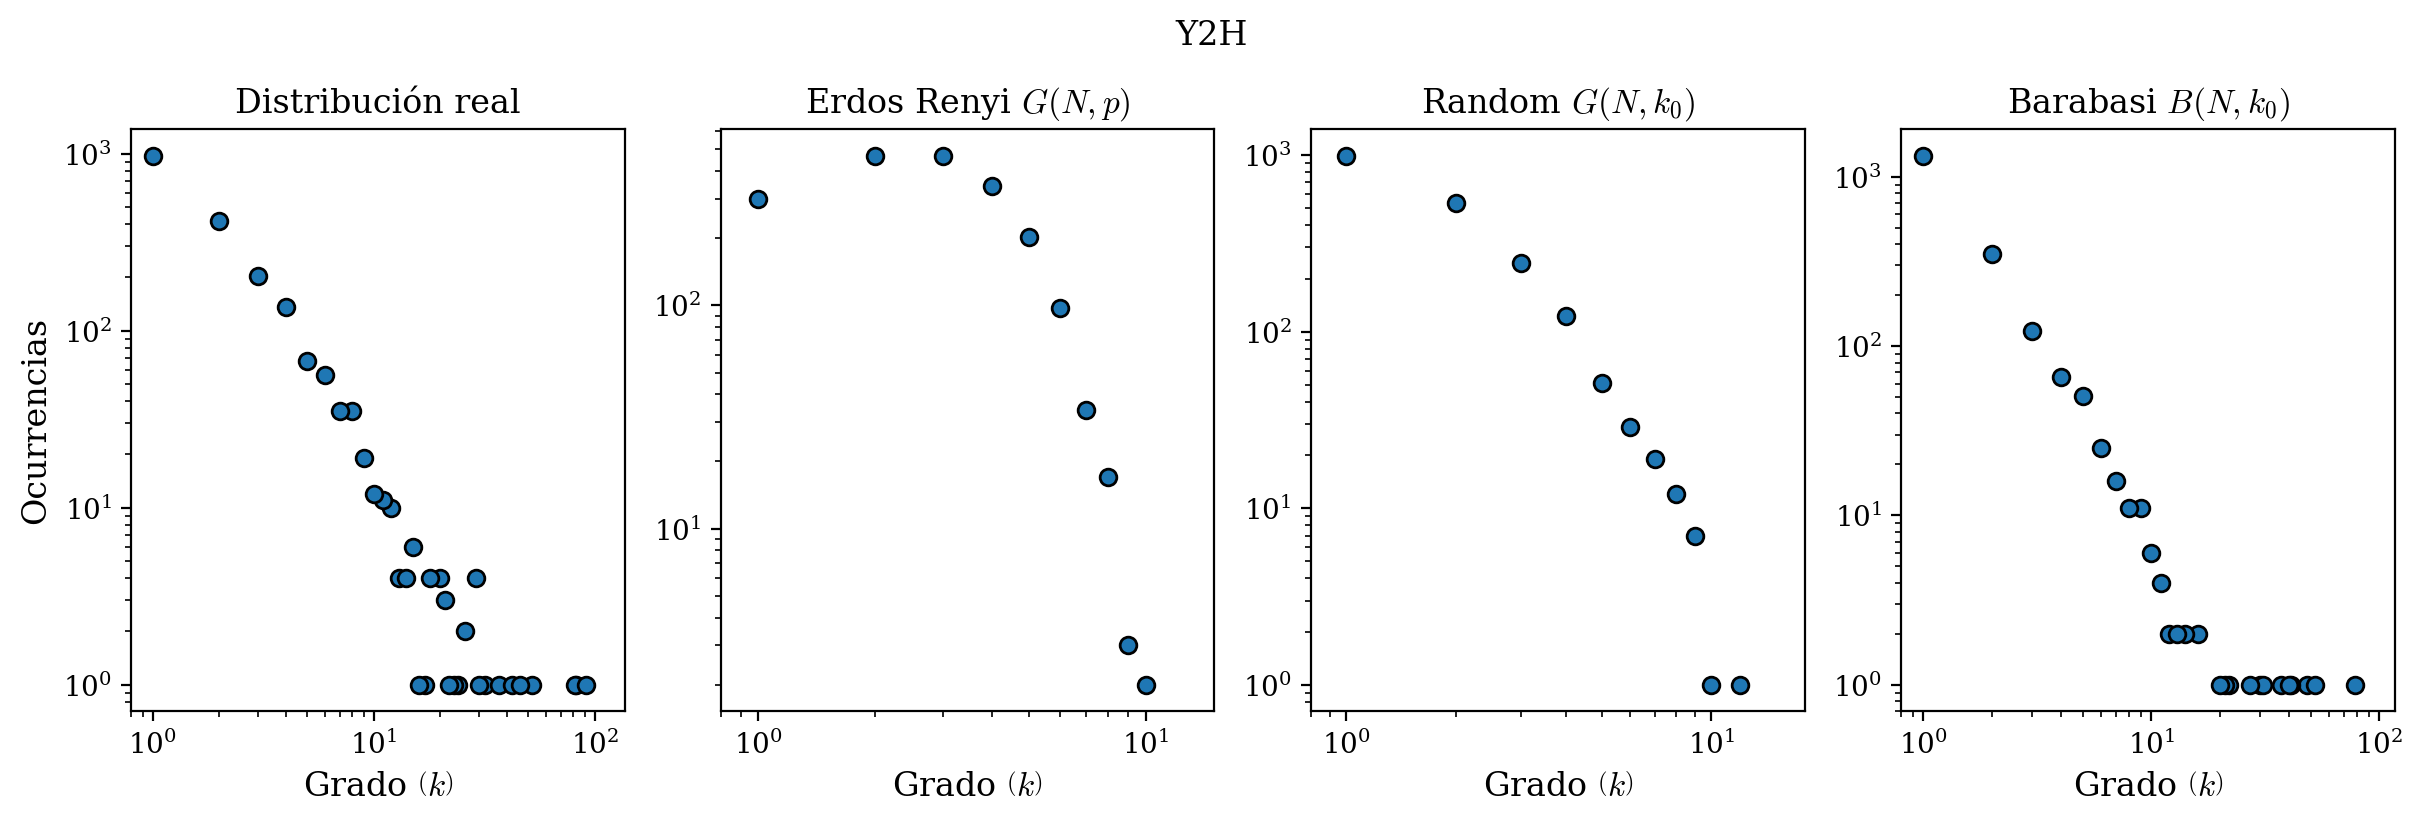

In [ ]:
plot_random_distributions(dict_graph["Y2H"], suptitle="Y2H")
plt.show()

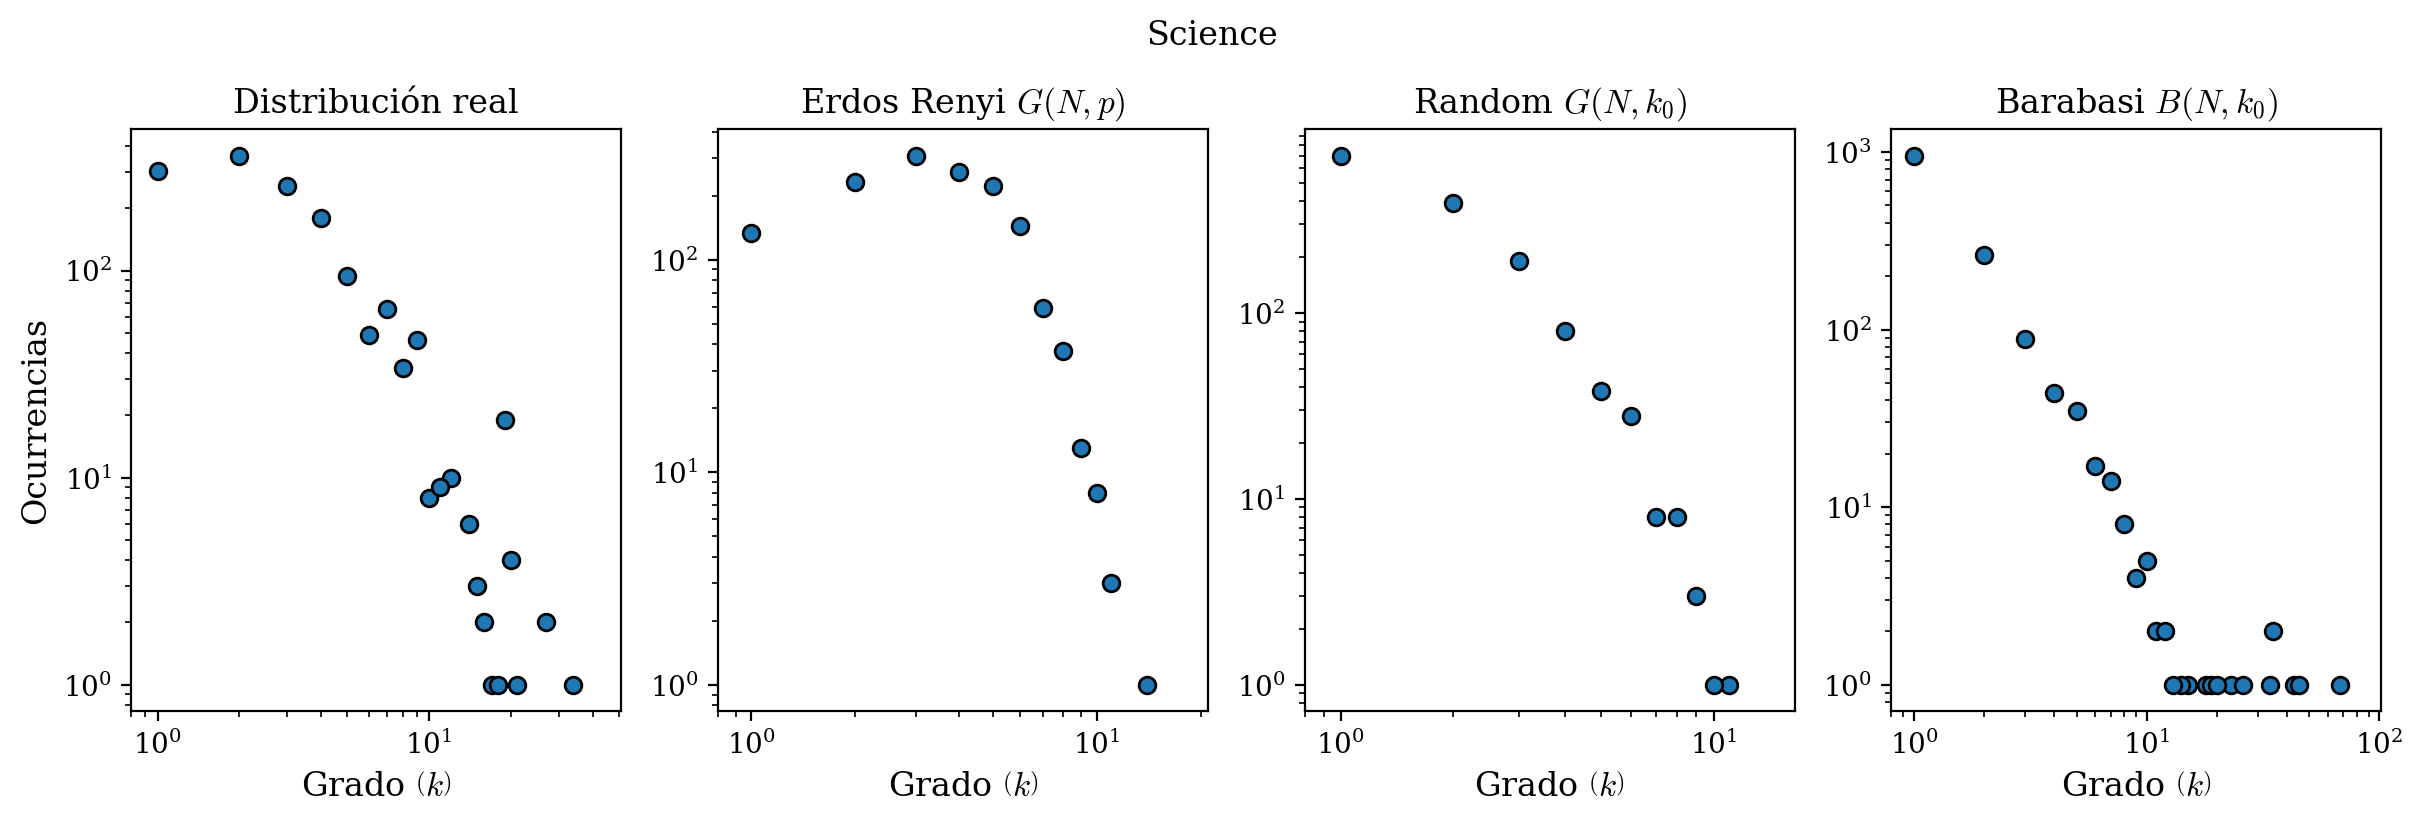

In [ ]:
plot_random_distributions(dict_graph["Science"], suptitle="Science")
plt.show()

In [ ]:
plot_random_distributions(dict_graph["Internet"], suptitle="Internet")
plt.show()

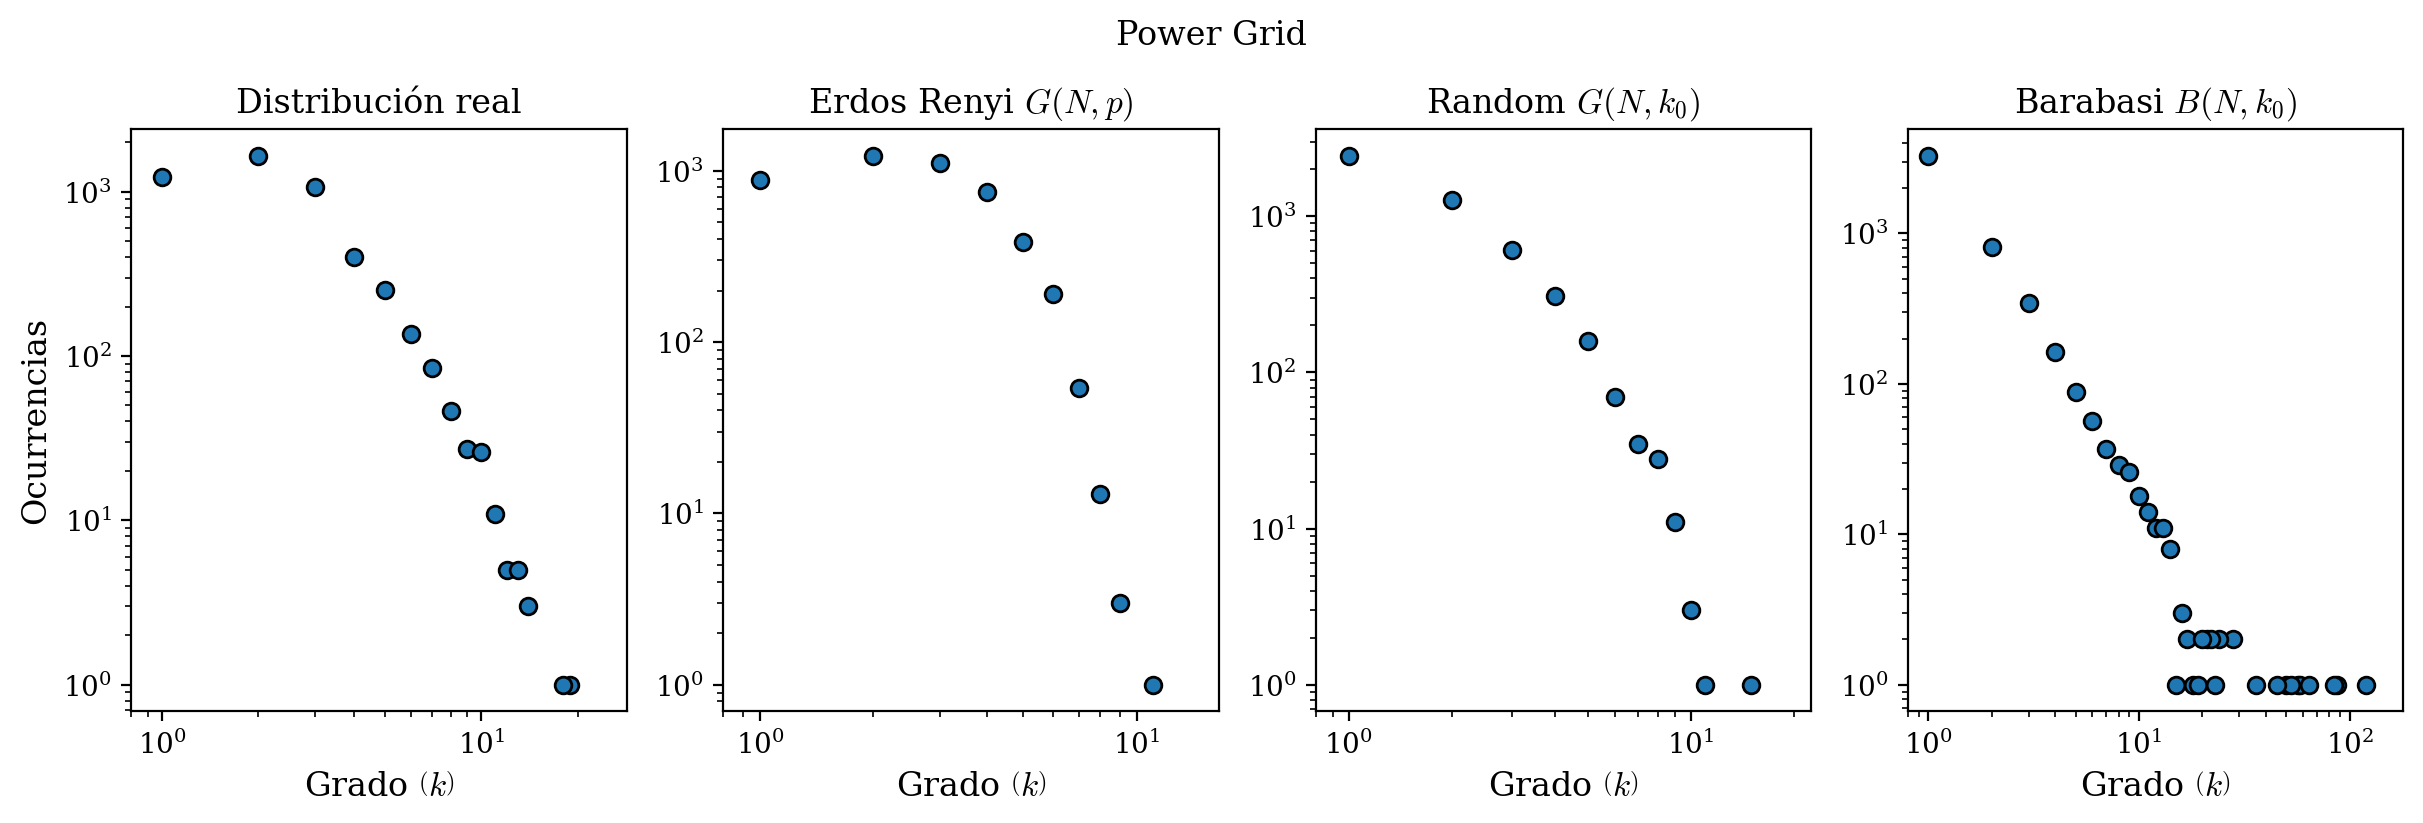

In [ ]:
plot_random_distributions(dict_graph["Power Grid"], suptitle="Power Grid")
plt.show()

Tanto para Y2H como para Internet se observa una distribución de grado similar a 
la de Barabasi, mientras que para Science y Power Grid la distribución se asemeja más a la de Erdos Renyi.

Mientras que las redes de Erdos Renyi son aleatorias por definición implicando una uniformidad en la formación de estas; las redes de Barabási requieren de ciertos tipos de interacciones que dan lugar a la generación de redes libres de escala: 
1- La red comienza con algunos nodos fuertemente interconectados, y se van incorporando nuevos nodos con el tiempo.
2- Los nuevos nodos se conectan preferencialmente con los nodos con mayor conectividad.

De este modo, al observar que las redes Y2H e Internet tienen una distribución de grados siguiendo una ley de potencias, se puede inducir que en su generación estuvieron presentes mecanismos de adhesión preferencial. En el caso de Internet, es razonable suponer que al crearse una nueva página, esta cite o direccione a las páginas más relevantes que ya existían. En el caso de Y2H, que la red tenga esta forma podría ser un indicio de la manera en la que la selección natural da lugar a la sintesis de ciertas proteínas que son capaces de interactuar con aquellos compuestos que ya estaban presentes en más interacciones preexistentes.

# II. Modelo configuracional

## 1) $\{d_i\}_{1 \leq i \leq N} (N, \langle k \rangle)$

In [ ]:
def poisson_degree_dist(N: int, mean_degree: float, seed: int = 42) -> np.ndarray:
    """
    Genera una distribución de grados segun la distribución de Poisson.
    """
    rng = np.random.default_rng(seed=seed)
    d = rng.poisson(lam=mean_degree, size=N)
    if sum(d)%2 != 0:
        # Para N suficientemente grande,
        # el efecto de agregar un grado es despreciable.
        random_ix = rng.integers(low=0, high=N, size=1)
        d[random_ix] += 1
    return d

## 2) $G(\{d_i\}_{1 \leq i \leq N})$

In [19]:
def configuration_model_graph(d : np.ndarray, max_err_iters: int, seed: int = 42) -> nx.Graph:
    """
    Genera un grafo aleatorio segun el "configurational model", a partir de una
    lista de la distribucion de grados de los nodos.
    `max_err_iters` es el numero maximo de iteraciones consecutivas en la cual
    el enlace elegido es repetido o autoenlace en el proceso de armado de enlaces.
    """
    rng = np.random.default_rng(seed=seed)
    N = len(d)  # Numero de nodos
    nodes = np.arange(N)  # Id's
    half_edges = []  # Aquí se guardan los extremos de los enlaces.
    for n, d_i in zip(nodes, d):
        half_edges += [n]*d_i
    edges = []  # Aca guardo la lista de enlaces entre nodos, como tuplas.
    half_edges_copy = half_edges.copy()
    error_count = 0  # Acumulador de iteraciones en las que el enlace propuesto resulta en un multienlace o en un autoenlace.
    while len(half_edges_copy) != 0:
        n1, n2 = rng.choice(a=half_edges_copy, size=2)
        if n1 == n2 or (n1, n2) in edges or (n2, n1) in edges:  # True si se está formando un autoenlace o multienlace.
            error_count += 1
            if error_count > max_err_iters:
                # Si los errores superan el umbral de tolerancia, vuelve a iniciar la construcción.
                edges = []
                half_edges_copy = half_edges.copy()
                error_count = 0
            continue
        else:
            edges += [(n1, n2)]  # Se agrega el enlace propuesto.
            half_edges_copy.remove(n1)
            half_edges_copy.remove(n2)  # Eliminación de los extremos de la lista.
            error_count = 0  # Reset error count
    G = nx.Graph()
    G.add_edges_from(edges)
    G.add_nodes_from(nodes)
    return G


In [20]:
# Ejemplo:
fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=150,
                       facecolor='w', constrained_layout=True)
N = 10000
mean_degree = 2
d = poisson_degree_dist(N, mean_degree)
example_net = configuration_model_graph(d, 10)
custom_draw(example_net, ax=ax, cmap='Reds', size_degree=True)
ax.set_title("Ejemplo de red $G(N=10000, \langle k \rangle=2)$")
plt.show()

Utilizamos la red de proteinas LIT, y comparamos su coeficiente de clustering medio con el 
de la red aleatoria generada a partir del configuration model

In [ ]:
path = '../TP1/datasets/LIT.txt'
df = pd.read_csv(path, delimiter="\t", header=None, names=["source", "target"])
# Cargamos todas las redes como grafos no dirigidos:
proteins = nx.from_pandas_edgelist(df, create_using=nx.Graph)
degree_dist = dict(proteins.degree()).values()
avg_C = nx.average_clustering(proteins)

try:
    with open("avg_C.list", "rb") as f:
        random_avg_C = pickle.load(f)
    
except FileNotFoundError:
    random_avg_C = []
    for i in tqdm(range(1000)):
        G = configuration_model_graph(degree_dist, 20, seed=i)
        random_avg_C.append(nx.average_clustering(G))
    with open("avg_C.list", "wb") as f:
        pickle.dump(random_avg_C, f)

print(f"Coeficiente medio de clustering en LIT: {avg_C:.2f}",
      f"Coeficiente medio de clustering en red aleatoria: {np.mean(random_avg_C):.4f} ± {np.std(random_avg_C):.2g}",
      sep='\n')


 29%|██▊       | 286/1000 [04:49<10:25,  1.14it/s]

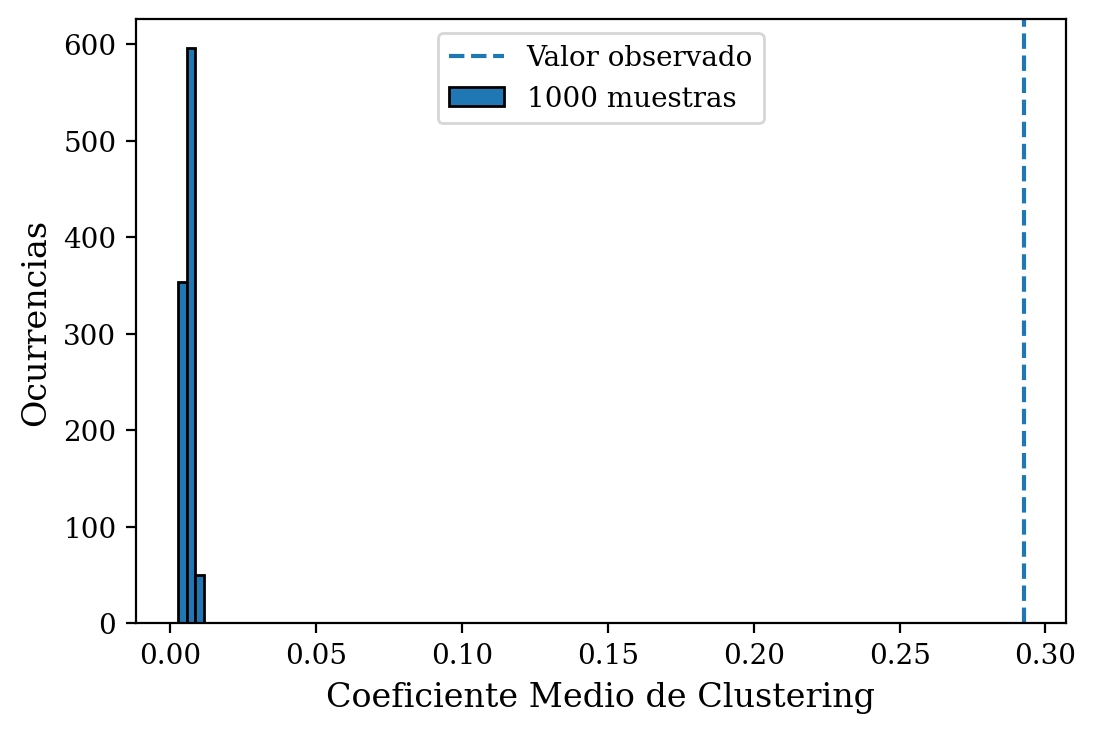

In [22]:
plt.figure(facecolor='w')
plt.hist(random_avg_C, bins=3, edgecolor='k', label=f"{len(random_avg_C)} muestras")
plt.axvline(avg_C, ls="--", label="Valor observado")
plt.legend(loc='upper center')
plt.xlabel("Coeficiente Medio de Clustering")
plt.ylabel("Ocurrencias")
plt.show()

Se observa que el coeficiente medio de clustering de la red de proteinas difiere significativamente del obtenido para redes aleatorias generadas con la misma distribucion de grado.